# word2vec implementation with keras
-----------------------------
reference:
- [Word2Vec keras 구현](https://byeongkijeong.github.io/Word2vec-from-scratch-using-keras/)
- [Word2Vec 구현하기(Skip-Gram with Negative Sampling, SGNS)](https://wikidocs.net/69141)

In [11]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\SHIN-
[nltk_data]     DESKTOP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# Corpus preprocessing
-------------------

In [12]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

news_df = pd.DataFrame({'document': documents})

# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

# 불용어를 제거

stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 11314
총 샘플 수 : 11314
총 샘플 수 : 10940


# Make the vocabulary set
------------------

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


## Modeling
----------------------

In [14]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

(commited (7837), unattended (18648)) -> 0
(reason (149), ignore (1979)) -> 1
(received (634), holocaust (2669)) -> 1
(israels (13686), eder (11834)) -> 0
(atrocities (4406), hsck (58411)) -> 0


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       6427700     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       6427700     input_3[0][0]                    
_______________________________________________________________________________________

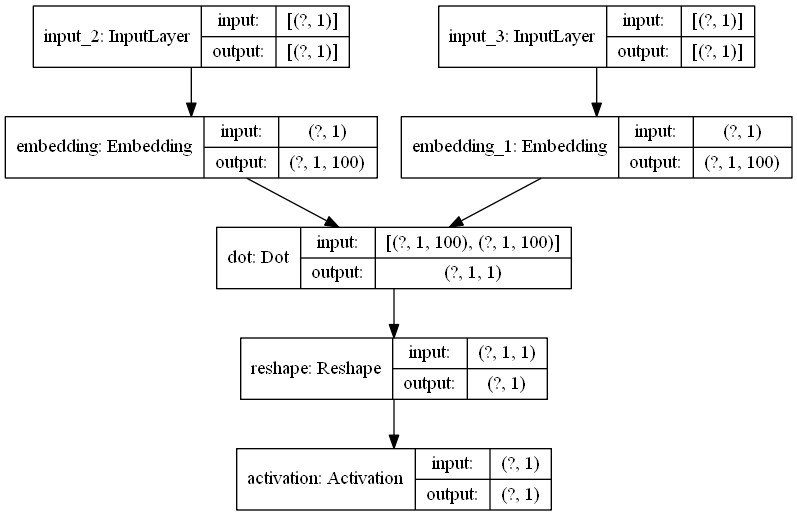

In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

embed_size = 100


# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [16]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4632.0614703297615
Epoch : 2 Loss : 3669.6043516770005
Epoch : 3 Loss : 3501.000122351572
Epoch : 4 Loss : 3300.112763788551
Epoch : 5 Loss : 3080.6260855020955


In [19]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

w2v = gensim.models.KeyedVectors.load_word2vec_format('vectors.txt', binary=False)
print(w2v.most_similar(positive=['soldiers']))
print(w2v.most_similar(positive=['doctor']))
print(w2v.most_similar(positive=['police']))


[('wounded', 0.8295235633850098), ('anatolia', 0.8083543181419373), ('massacred', 0.7971622943878174), ('lebanese', 0.7958395481109619), ('shelling', 0.7953344583511353), ('artillery', 0.7935691475868225), ('turkiye', 0.7931700348854065), ('germans', 0.7891702651977539), ('slaughtered', 0.7886993288993835), ('massacre', 0.785638689994812)]
[('therapy', 0.6043286919593811), ('treatment', 0.5923689007759094), ('headaches', 0.5664941072463989), ('patient', 0.5650861263275146), ('diagnosed', 0.564429521560669), ('medication', 0.5643908381462097), ('oral', 0.557369589805603), ('quack', 0.5537638068199158), ('legalization', 0.5442377328872681), ('humans', 0.5407813787460327)]
[('intensify', 0.6158971786499023), ('attorney', 0.609848141670227), ('violations', 0.6072036623954773), ('federal', 0.6042728424072266), ('military', 0.5997077226638794), ('occupying', 0.5943095684051514), ('volunteers', 0.5906938314437866), ('terretories', 0.5896093845367432), ('dictatorship', 0.5893772840499878), ('n